In [1]:
## This version excludes CONTINUOUS Variables and the RFD variables AND _wHICH VARIABLES 3/27/2024 and con_max_consultorder_time/day and drg name
## 4/4/2024 Added QUINTILE variables
## 4/8/2024 Added QUINTILE varables by service
## 4/9/2024 Added more consult and imaging variables (e.g. ad,it order to consult order, admit order to imaging read)
## 4/11/2024 Added QUINTILE variables by service for the additional variables
# 06/12/2024: Added gender, added imaging_order_before_consult_order and consult_order_before_imaging order variables, excluded 290 patients in 2022, dropped raw race/insurance categories
# 06/14/2024: Removed quintiles
# 06/20/2024: Set seed for reproducibility
# 06/22/2024: Added sample size for validation
# 07/05/2024: Collapsed Cardiology into Medicine
# 07/08/2024: Added labels

In [2]:
import pandas as pd
import numpy as np

#ML packages
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from feature_engine.discretisation import DecisionTreeDiscretiser
from sklearn.model_selection import GroupShuffleSplit
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, roc_auc_score, classification_report, precision_recall_curve, roc_curve, auc
from sklearn.calibration import calibration_curve

#XGBo
#https://github.com/liannewriting/YouTube-videos-public/blob/main/xgboost-python-tutorial-example/xgboost_python.ipynb
import xgboost as xgb
from category_encoders.target_encoder import TargetEncoder
from xgboost import XGBClassifier
#hyperparameter values
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

#Feature Selection
from feature_engine.selection import DropConstantFeatures, DropDuplicateFeatures, SmartCorrelatedSelection
from feature_engine.encoding import OneHotEncoder
from feature_engine.selection import DropFeatures, DropConstantFeatures, DropDuplicateFeatures, SmartCorrelatedSelection
from feature_engine.imputation import AddMissingIndicator
from feature_engine.outliers import Winsorizer
from feature_engine.wrappers import SklearnTransformerWrapper
from feature_engine.imputation import ArbitraryNumberImputer
from feature_engine.imputation import MeanMedianImputer
from feature_engine.imputation import CategoricalImputer
from feature_engine.encoding import RareLabelEncoder

#Plotting Packages
import shap
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [3]:
def map_med (value):
    if value in ["Cardiology", "Medicine"]:
        return "Medicine"
    else:
        return value

### Filtering for specific patients

In [4]:
df_all = pd.read_csv('/gpfs/milgram/project/rtaylor/imc33/LOS/data/master_los.csv', index_col=[0])

In [5]:
pd.set_option('display.max_columns', None)

In [6]:
df_all.shape

(12771, 907)

In [7]:
df_all["viz_disp_collapsed"].value_counts()

viz_disp_collapsed
Other    8022
Home     4749
Name: count, dtype: int64

In [8]:
df_all["imaging_order_before_consult_order"].value_counts()

imaging_order_before_consult_order
True     1351
False     236
Name: count, dtype: int64

In [9]:
df_all["viz_service_collapsed"].value_counts()

viz_service_collapsed
Medicine             9837
Cardiology           1644
Neurology             876
Surgical Services     414
Name: count, dtype: int64

In [10]:
df_all["viz_service_collapsed"] = df_all["viz_service_collapsed"].apply(map_med)

In [11]:
df_all["viz_service_collapsed"].value_counts()

viz_service_collapsed
Medicine             11481
Neurology              876
Surgical Services      414
Name: count, dtype: int64

In [12]:
#Filter for home patients
#df_filt = df_all.copy()
df_filt = df_all[df_all["viz_disp_collapsed"] == "Home"].copy()
#df_filt = df_all[df_all["thro_boarding_yn"] == 1].copy()

In [13]:
df_filt.shape

(4749, 907)

In [14]:
features_los = pd.read_excel('/gpfs/milgram/project/rtaylor/imc33/LOS/data/features_los.xlsx')

# Features that are divided into 5 types to conduct data preprocessing
# 1. drop: features that need to be dropped
drop_list = features_los[features_los['type'] == 'drop']['col_name'].tolist()

# 2. category: features that are already categorical and need to be OneHotEncoding (add missing value indicator, impute missing by adding 'missing' category)
category_list = features_los[features_los['type'] == 'category']['col_name'].tolist()

# 3. binary: features that are binary and need to be converted to categorical (add missing value indicator / prefer: fill missing with 0)
binary_list = features_los[features_los['type'] == 'binary']['col_name'].tolist()

# 4. continuous: features that are continous/numerical variables, need outlier handling and normalization (add missing value indicator, fill missing with median)
continuous_list = features_los[features_los['type'] == 'continuous']['col_name'].tolist()

# 5. discrete: features that are discrete/numerical variables, need to be discretized (fill missing with 0)
discrete_list = features_los[features_los['type'] == 'discrete']['col_name'].tolist()

In [15]:
# Split into X, y
X = df_filt.drop(['viz_outcome_prolonged_los_yn'], axis=1)
y = df_filt['viz_outcome_prolonged_los_yn']

In [16]:
# Convert variables to categorical
X[binary_list] = X[binary_list].astype('category')
X[category_list] = X[category_list].astype('category')

In [17]:
#missing_pct.reset_index().sort_values(0, ascending=False).head()

In [18]:
continuous_list.remove("viz_age")

In [19]:
#Check drop list
#drop_list

In [20]:
X = X.drop(columns=drop_list+continuous_list)
X = X.reset_index()
y = y.reset_index()

In [21]:
# Split the data by group shuffle split on 'PAT_MRN_ID' into train set and validation set
gss = GroupShuffleSplit(n_splits=2, test_size=0.2, random_state=42)

train_ix, val_ix = next(gss.split(X, y, groups=X['pat_mrn_id']))

X_train = X.loc[train_ix]
y_train = y.loc[train_ix]

X_val = X.loc[val_ix]
y_val = y.loc[val_ix]

# Drop 'PAT_MRN_ID' and set 'PAT_ENC_CSN_ID' as index
X_train = X_train.drop(['pat_mrn_id'], axis=1).set_index('pat_enc_csn_id')
X_val = X_val.drop(['pat_mrn_id'], axis=1).set_index('pat_enc_csn_id')

In [22]:
# Update feature preprocessing pipeline
feature_preprocess_pipeline = Pipeline(steps=[

    # Missing value imputation
    # Impute missing values with 0 for discrete variables
    ('arbitrary_number_imputer', ArbitraryNumberImputer(arbitrary_number=0, variables=discrete_list)),

  
    # Impute missing values with adding 'missing' category for categorical variables 
   ('categorical_imputer', CategoricalImputer(variables=category_list)),

    # Impute missing values with 0 for binary variables 
    ('binary_imputer', CategoricalImputer(fill_value='0', variables=binary_list)),

    
    # Rare encoding for categorical variables
    ('rare_label_encoder', RareLabelEncoder(tol=0.01, n_categories=5, max_n_categories=10, variables=category_list)),

    # OneHotEncoding for categoricals
    ('one_hot_category', OneHotEncoder(variables=category_list)),
    
])  # Apply the pipeline

In [23]:
# Apply the pipeline
X_train_preprocessed = feature_preprocess_pipeline.fit_transform(X_train, y_train)
X_val_preprocessed = feature_preprocess_pipeline.transform(X_val)

In [24]:
X_train_preprocessed.shape

(3814, 1477)

### Feature Selection

In [25]:
# 1st Feature Selection pipeline
feature_selection_pipeline = Pipeline(steps=[

        ('drop_constant', DropConstantFeatures(tol=0.99)),

        ('drop_duplicates', DropDuplicateFeatures()),

        ('correlated_features', SmartCorrelatedSelection(
        method='pearson',
        threshold=0.9,
        selection_method='model_performance',
        estimator=xgb.XGBClassifier(random_state=0)
        ))
])

### XGB Model

In [26]:
# Apply the pipeline
X_train_selected = feature_selection_pipeline.fit_transform(X_train_preprocessed, y_train['viz_outcome_prolonged_los_yn'])
X_val_selected = feature_selection_pipeline.transform(X_val_preprocessed)

In [27]:
X_train_selected.shape

(3814, 524)

In [28]:
y_train['viz_outcome_prolonged_los_yn'].sum()/y_train.shape[0]

0.3618248557944415

In [29]:
estimators = [
    ('encoder', TargetEncoder()),
    ('clf', XGBClassifier(random_state=8, verbosity=1))
]

tuning_pipeline = Pipeline(steps=estimators)

In [30]:
search_space = {
    'clf__max_depth': Integer(2,8),
    'clf__learning_rate': Real(0.001, 1.0, prior='log-uniform'),
    'clf__subsample': Real(0.5, 1.0),
    'clf__colsample_bytree': Real(0.5, 1.0),
    'clf__colsample_bylevel': Real(0.5, 1.0),
    'clf__colsample_bynode' : Real(0.5, 1.0),
    'clf__reg_alpha': Real(0.0, 10.0),
    'clf__reg_lambda': Real(0.0, 10.0),
    'clf__gamma': Real(0.0, 10.0)
}

model_xgb = BayesSearchCV(tuning_pipeline, search_space, cv=3, n_iter=10, scoring='roc_auc', random_state=8) 

In [31]:
y_train = y_train.set_index('pat_enc_csn_id')

In [32]:
model_xgb.fit(X_train_selected,  y_train)

BayesSearchCV(cv=3,
              estimator=Pipeline(steps=[('encoder', TargetEncoder()),
                                        ('clf',
                                         XGBClassifier(base_score=None,
                                                       booster=None,
                                                       callbacks=None,
                                                       colsample_bylevel=None,
                                                       colsample_bynode=None,
                                                       colsample_bytree=None,
                                                       device=None,
                                                       early_stopping_rounds=None,
                                                       enable_categorical=False,
                                                       eval_metric=None,
                                                       feature_types=None,
                                                       gamma=None,
                                                       grow_policy=None,
                                                       importance_type=N...
                             'clf__learning_rate': Real(low=0.001, high=1.0, prior='log-uniform', transform='normalize'),
                             'clf__max_depth': Integer(low=2, high=8, prior='uniform', transform='normalize'),
                             'clf__reg_alpha': Real(low=0.0, high=10.0, prior='uniform', transform='normalize'),
                             'clf__reg_lambda': Real(low=0.0, high=10.0, prior='uniform', transform='normalize'),
                             'clf__subsample': Real(low=0.5, high=1.0, prior='uniform', transform='normalize')})

In [33]:
model_xgb.best_estimator_

Pipeline(steps=[('encoder',
                 TargetEncoder(cols=['thro_boarding_yn',
                                     'con_max_consult_order_to_sign_is_signer_ym_provider_yn',
                                     'con_max_consult_order_to_sign_is_signer_nemg_provider_yn',
                                     'con_max_consult_order_to_sign_is_signer_community_provider_yn',
                                     'icu_any_icu_yn'])),
                ('clf',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=0...
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.7929828265552742, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=7,
                               max_leaves=None, min_child_weight=None,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=None,
                               n_jobs=None, num_parallel_tree=None,
                               random_state=8, ...))])

In [34]:
model_xgb.best_score_

0.7731427855519132

In [35]:
y_val = y_val.set_index('pat_enc_csn_id')

In [36]:
#Column 1 and Column 2 are the probabilities that the label is 0 or 1 
y_probs = model_xgb.predict_proba(X_val_selected)
y_pred = model_xgb.predict(X_val_selected)
#Only select the positive class
y_probs_positive = y_probs[:,1]
y_test = y_val['viz_outcome_prolonged_los_yn']

In [37]:

def plot_metrics(y_test, y_probs_positive):
    fig, axes = plt.subplots(3, 1, figsize=(10, 18))  # 3 rows x 1 column

    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_probs_positive)
    roc_auc = auc(fpr, tpr)
    axes[0].plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
    axes[0].plot([0, 1], [0, 1], 'k--', lw=2)
    axes[0].set_xlabel('False Positive Rate')
    axes[0].set_ylabel('True Positive Rate')
    axes[0].set_title('ROC Curve')
    axes[0].legend()

    # Plot PR Curve
    precision, recall, _ = precision_recall_curve(y_test, y_probs_positive)
    pr_auc = auc(recall, precision)
    axes[1].plot(recall, precision, label=f'PR-AUC = {pr_auc:.2f}')
    axes[1].set_xlabel('Recall')
    axes[1].set_ylabel('Precision')
    axes[1].set_title('PR Curve')
    axes[1].legend()

    # Plot Calibration Curve
    prob_true, prob_pred = calibration_curve(y_test, y_probs_positive, n_bins=10)
    axes[2].plot(prob_pred, prob_true, label='Calibration')
    axes[2].plot([0, 1], [0, 1], 'k--', label='Perfectly Calibrated')
    axes[2].set_xlabel('Mean Predicted Probability')
    axes[2].set_ylabel('Fraction of Positives')
    axes[2].set_title('Calibration Curve')
    axes[2].legend()

    plt.tight_layout()
    plt.show()

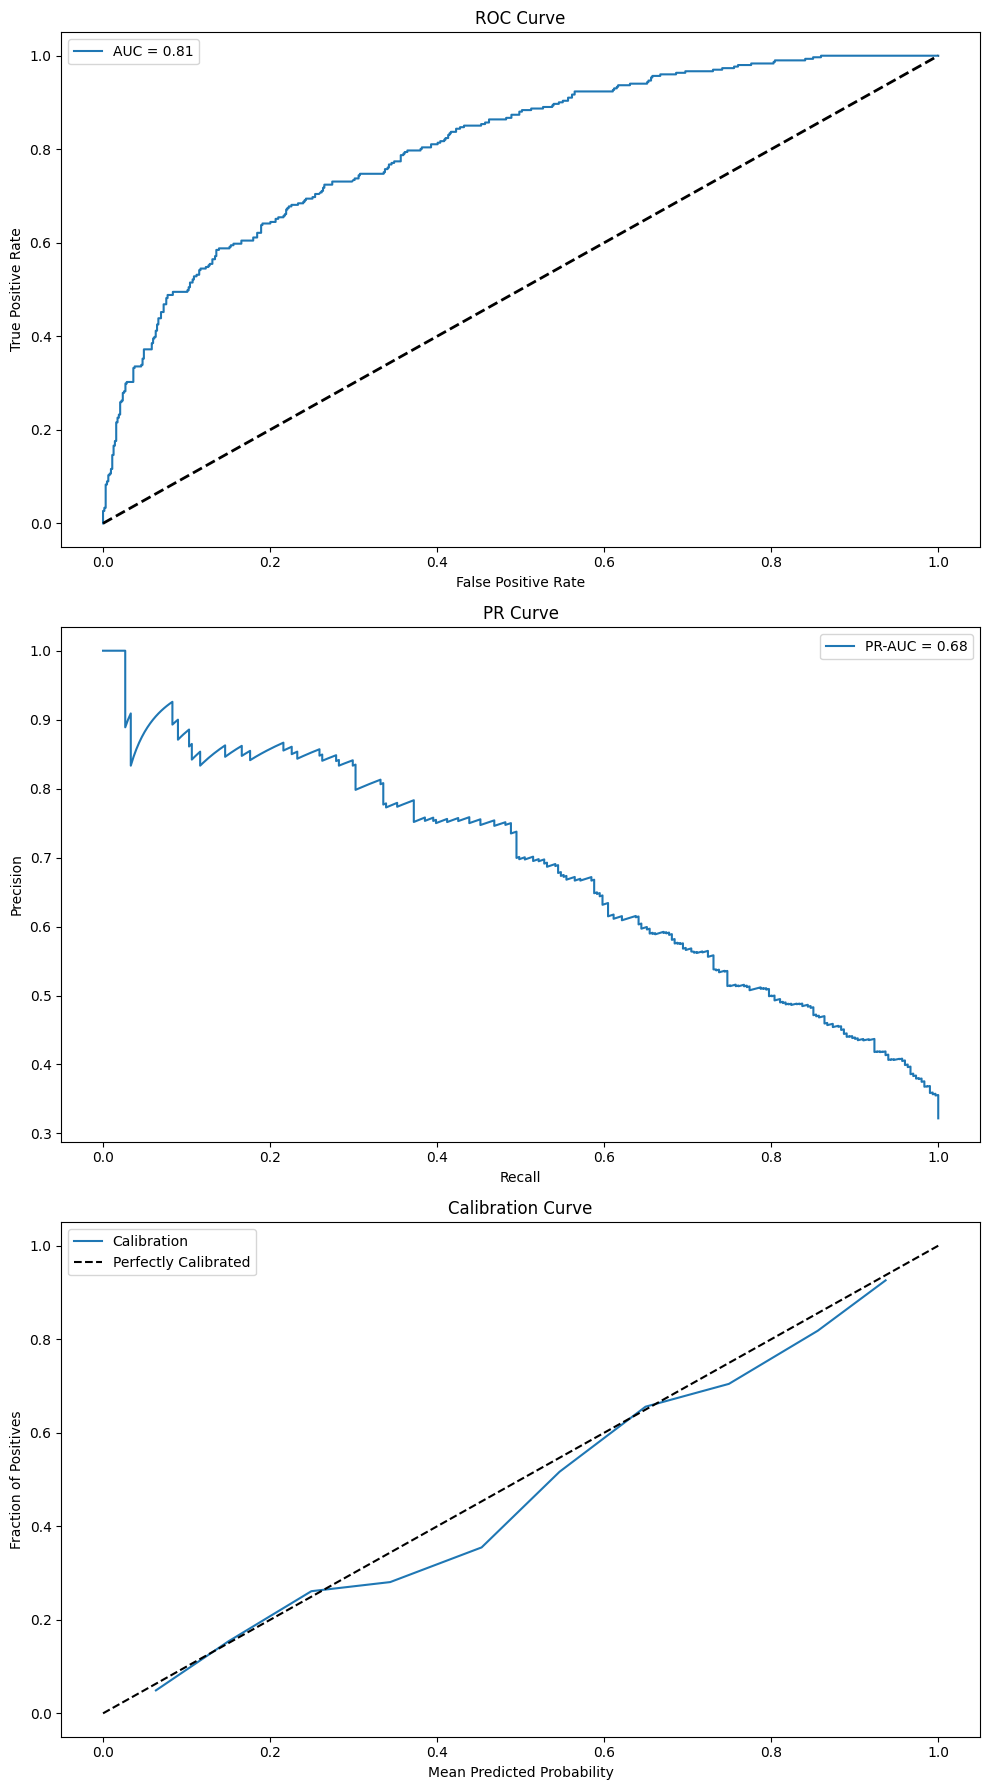

In [38]:
plot_metrics(y_test, y_probs_positive)

In [39]:

def plot_cm(y_test, y_pred):
    # Generate confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()
    
    # Extract values for binary classification
    tn = cm[0, 0]
    fp = cm[0, 1]
    fn = cm[1, 0]
    tp = cm[1, 1]
    
    # Calculate metrics
    top_row = tn + fp
    bot_row = fn + tp
    
    specificity_value = recall_score(y_test, y_pred, pos_label=0)
    sensitivity_value = recall_score(y_test, y_pred, pos_label=1)
    accuracy_value = accuracy_score(y_test, y_pred)
    precision_value = precision_score(y_test, y_pred)
    f1_value = f1_score(y_test, y_pred)
    
    # Print results
    print(f'Specificity : {specificity_value:.4f}')
    print(f'Sensitivity : {sensitivity_value:.4f}')
    print(f'Accuracy : {accuracy_value:.4f}')
    print(f'Precision : {precision_value:.4f}')
    print(f'F1 score : {f1_value:.4f}')
    
    print(f'Of {top_row} people who did not have a prolonged LOS, {tn} ({specificity_value:.2%}) were correctly classified.')
    print(f'Of {bot_row} people who did have a prolonged LOS, {tp} ({sensitivity_value:.2%}) were correctly classified.')



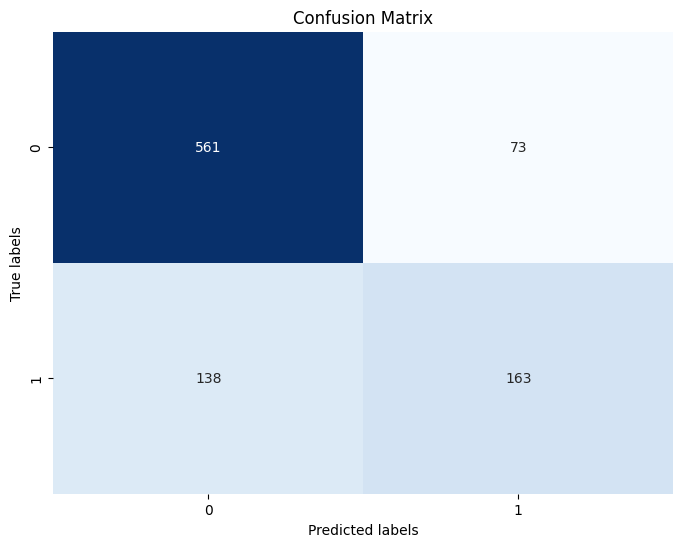

Specificity : 0.8849
Sensitivity : 0.5415
Accuracy : 0.7743
Precision : 0.6907
F1 score : 0.6071
Of 634 people who did not have a prolonged LOS, 561 (88.49%) were correctly classified.
Of 301 people who did have a prolonged LOS, 163 (54.15%) were correctly classified.


In [40]:
plot_cm(y_test, y_pred)

### SHAP plots

In [41]:
model_xgb.best_estimator_.steps

[('encoder',
  TargetEncoder(cols=['thro_boarding_yn',
                      'con_max_consult_order_to_sign_is_signer_ym_provider_yn',
                      'con_max_consult_order_to_sign_is_signer_nemg_provider_yn',
                      'con_max_consult_order_to_sign_is_signer_community_provider_yn',
                      'icu_any_icu_yn'])),
 ('clf',
  XGBClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=0.9425384185492701,
                colsample_bynode=0.9095956806239844,
                colsample_bytree=0.706128679361455, device=None,
                early_stopping_rounds=None, enable_categorical=False,
                eval_metric=None, feature_types=None, gamma=1.6598135411398998,
                grow_policy=None, importance_type=None,
                interaction_constraints=None, learning_rate=0.7929828265552742,
                max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=None, max_dept

In [42]:
train_fp = '/gpfs/milgram/project/rtaylor/imc33/LOS/data/pipeline/los_train_initial_selected.csv'
val_fp = '/gpfs/milgram/project/rtaylor/imc33/LOS/data/pipeline/los_val_initial_selected.csv'

X_train_selected.to_csv(train_fp)
X_val_selected.to_csv(val_fp)

X_train_selected = pd.read_csv(train_fp, index_col=[0])
X_val_selected = pd.read_csv(val_fp, index_col=[0])

In [43]:
X_val_selected.shape

(935, 524)

In [44]:
# Set seeds for reproducibility
np.random.seed(42)

In [45]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic', missing=None, seed=42)
clf_xgb.fit(X_train_selected, 
            y_train['viz_outcome_prolonged_los_yn'], 
            verbose=True,
            early_stopping_rounds=10,
            eval_metric='aucpr',
            eval_set=[(X_val_selected, y_val['viz_outcome_prolonged_los_yn'])])

[0]	validation_0-aucpr:0.60114


[1]	validation_0-aucpr:0.60556


[2]	validation_0-aucpr:0.62472


[3]	validation_0-aucpr:0.63274


[4]	validation_0-aucpr:0.64253


[5]	validation_0-aucpr:0.65409


[6]	validation_0-aucpr:0.66738


[7]	validation_0-aucpr:0.67284


[8]	validation_0-aucpr:0.67885


[9]	validation_0-aucpr:0.67568


[10]	validation_0-aucpr:0.67779


[11]	validation_0-aucpr:0.68215


[12]	validation_0-aucpr:0.68930


[13]	validation_0-aucpr:0.68989


[14]	validation_0-aucpr:0.68881


[15]	validation_0-aucpr:0.68951


[16]	validation_0-aucpr:0.68864


[17]	validation_0-aucpr:0.69071


[18]	validation_0-aucpr:0.69746


[19]	validation_0-aucpr:0.69952


[20]	validation_0-aucpr:0.70995


[21]	validation_0-aucpr:0.71200


[22]	validation_0-aucpr:0.71485


[23]	validation_0-aucpr:0.71417


[24]	validation_0-aucpr:0.71568


[25]	validation_0-aucpr:0.72134


[26]	validation_0-aucpr:0.71869


[27]	validation_0-aucpr:0.72260


[28]	validation_0-aucpr:0.72117


[29]	validation_0-aucpr:0.72332


[30]	validation_0-aucpr:0.72291


[31]	validation_0-aucpr:0.72206


[32]	validation_0-aucpr:0.72224


[33]	validation_0-aucpr:0.72272


[34]	validation_0-aucpr:0.72558


[35]	validation_0-aucpr:0.72841


[36]	validation_0-aucpr:0.72984


[37]	validation_0-aucpr:0.73286


[38]	validation_0-aucpr:0.73361

[39]	validation_0-aucpr:0.73288

[40]	validation_0-aucpr:0.73492

[41]	validation_0-aucpr:0.73443


[42]	validation_0-aucpr:0.73238

[43]	validation_0-aucpr:0.73347

[44]	validation_0-aucpr:0.73418

[45]	validation_0-aucpr:0.73390


[46]	validation_0-aucpr:0.73493


[47]	validation_0-aucpr:0.73531


[48]	validation_0-aucpr:0.73493


[49]	validation_0-aucpr:0.73539


[50]	validation_0-aucpr:0.73432


[51]	validation_0-aucpr:0.73543


[52]	validation_0-aucpr:0.73595


[53]	validation_0-aucpr:0.73554


[54]	validation_0-aucpr:0.73589


[55]	validation_0-aucpr:0.73526


[56]	validation_0-aucpr:0.73574


[57]	validation_0-aucpr:0.73691


[58]	validation_0-aucpr:0.73697


[59]	validation_0-aucpr:0.73910


[60]	validation_0-aucpr:0.73705


[61]	validation_0-aucpr:0.73646


[62]	validation_0-aucpr:0.73772


[63]	validation_0-aucpr:0.73634


[64]	validation_0-aucpr:0.73514


[65]	validation_0-aucpr:0.73489


[66]	validation_0-aucpr:0.73430


[67]	validation_0-aucpr:0.73850


[68]	validation_0-aucpr:0.73805


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=None, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [46]:
explainer = shap.Explainer(clf_xgb)
shap_values = explainer(X_val_selected)

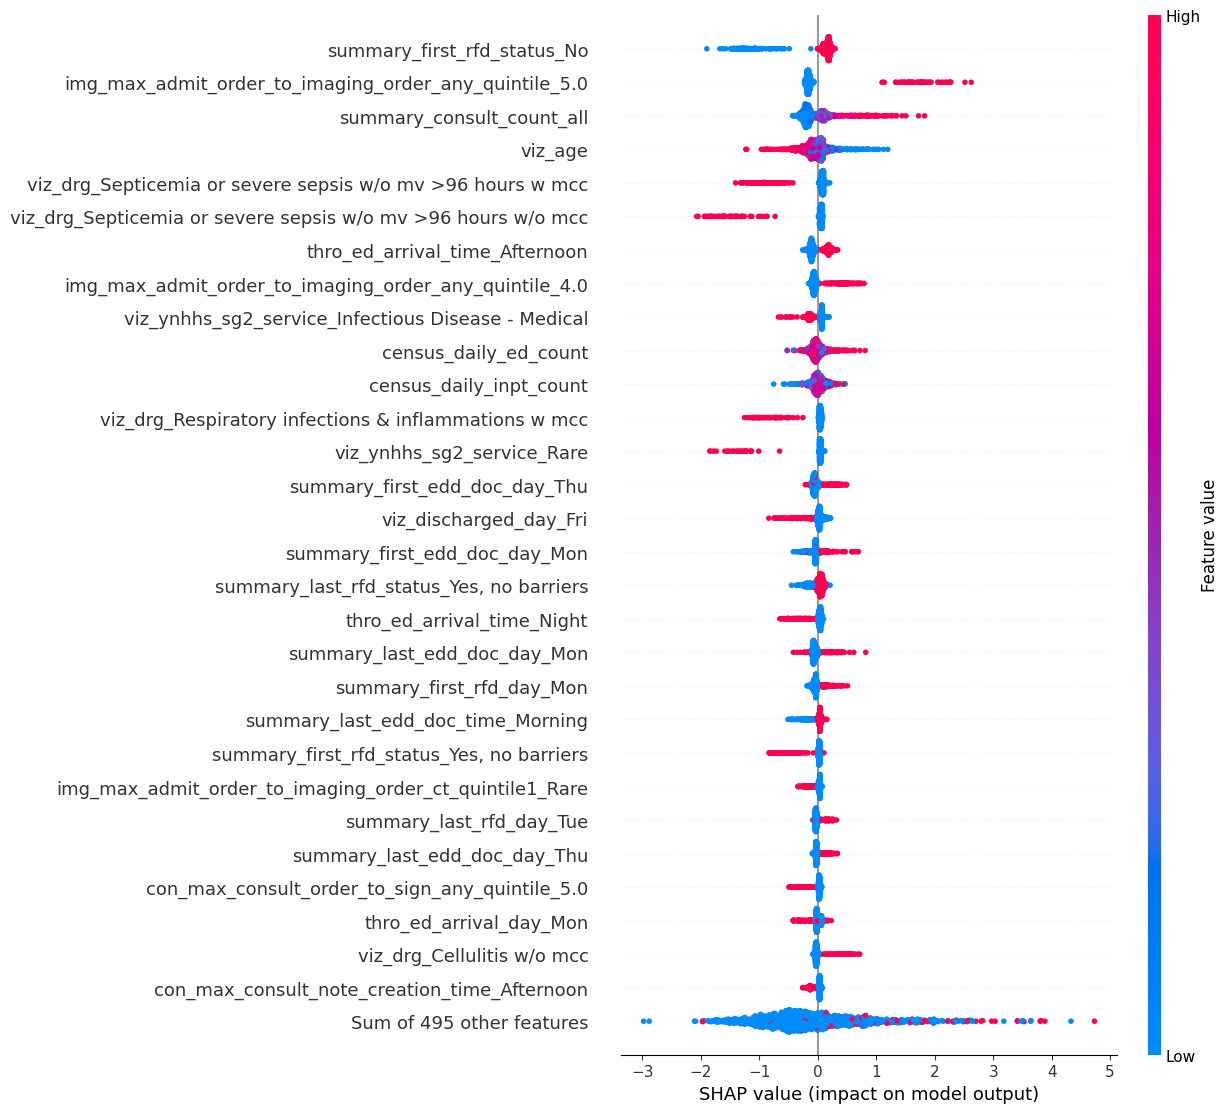

In [47]:
shap.plots.beeswarm(shap_values, max_display=30)

In [48]:
shap_df = pd.DataFrame(shap_values.values, columns=shap_values.feature_names)

In [49]:
mean_abs_shap = np.abs(shap_df).mean(axis=0)

In [50]:
top_30_features = mean_abs_shap.sort_values(ascending=False).head(30)


In [51]:
for feature in top_30_features.index.tolist():
    print(feature)

summary_first_rfd_status_No
img_max_admit_order_to_imaging_order_any_quintile_5.0
summary_consult_count_all
viz_age
viz_drg_Septicemia or severe sepsis w/o mv >96 hours w mcc
viz_drg_Septicemia or severe sepsis w/o mv >96 hours w/o mcc
thro_ed_arrival_time_Afternoon
img_max_admit_order_to_imaging_order_any_quintile_4.0
viz_ynhhs_sg2_service_Infectious Disease - Medical
census_daily_ed_count
census_daily_inpt_count
viz_drg_Respiratory infections & inflammations w mcc
viz_ynhhs_sg2_service_Rare
summary_first_edd_doc_day_Thu
viz_discharged_day_Fri
summary_first_edd_doc_day_Mon
summary_last_rfd_status_Yes, no barriers
thro_ed_arrival_time_Night
summary_last_edd_doc_day_Mon
summary_first_rfd_day_Mon
summary_last_edd_doc_time_Morning
summary_first_rfd_status_Yes, no barriers
img_max_admit_order_to_imaging_order_ct_quintile1_Rare
summary_last_rfd_day_Tue
summary_last_edd_doc_day_Thu
con_max_consult_order_to_sign_any_quintile_5.0
thro_ed_arrival_day_Mon
viz_drg_Cellulitis w/o mcc
con_max_consu

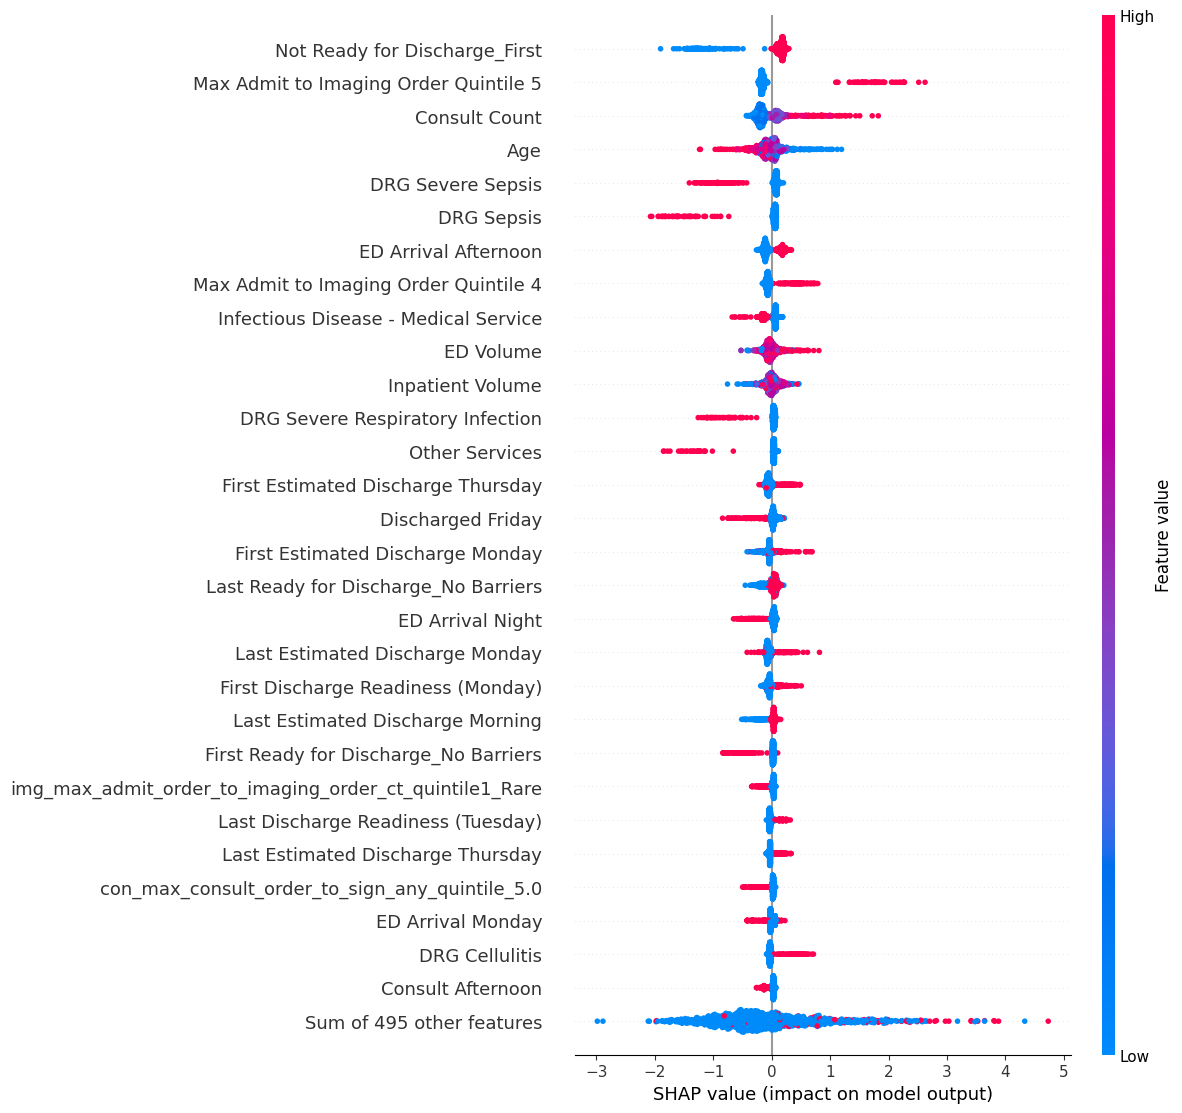

In [52]:
lab_df = pd.read_csv('/gpfs/milgram/project/rtaylor/imc33/LOS/data/new_label_names.csv')

new_feature_names_dict = pd.Series(lab_df.new_name.values, index=lab_df.old_name).to_dict()

current_feature_names = shap_values.feature_names  # Current feature names

# Update feature names in the SHAP values object
new_feature_names = [new_feature_names_dict.get(name, name) for name in current_feature_names]
shap_values.feature_names = new_feature_names

# Generate the beeswarm plot with the updated feature names
shap.plots.beeswarm(shap_values, max_display=30)